In [23]:
using CSV, DataFrames, LinearAlgebra, Graphs, Printf, Distributions
using SpecialFunctions, Random, SparseArrays

In [276]:
# Defined the reward from our baseline because I didn't feel like pulling from the CSV

R1 = [0, -11, -11, -11, 0, -11, 0, 0, 0, -11, 0,
      0, 10, -1, 10, -1, -1, -11, 0, 0, 0, -1, 10,
     -1, 10, 10, -1, -1, -11, 0, 0, -1, -1, -1, 10, 
     -1, -1, 10,0,-11,0,-500, 100,-1, 0,-1,-1,10,-11,
    -11,0, 10, -500, -1, 10, 10, -1, 10, 0, 0, -11, 10, 
    10, -1, -1,10,-1,-500,-11,0,-11,0,-1,-1,10,10,-1,90,
    -510,0,0,0,-11,0,0,-11,-11,0,-11,0,-11,0,0,0,-11,-11,
    -11,0,0,0]

R_mat = reshape(R1, 10, 10)'

R_new = reshape(R_mat, 100, 1);

### Q-learning Function

In [338]:
using LinearAlgebra

Random.seed!(228)

function sub2ind(siz, x)
    idx = LinearIndices(Tuple(siz))
    cart = CartesianIndex(Tuple(x))
    return idx[cart]
end

function next_state(s, a, transition, n)
    #Actions: Up(1), Down(2), Left(3), Right(4)
    
    sp = s + get(transition, a, 0)
    
    #If moving into left or right boundary, then no change in state.
    #i.e. In a 10x10 grid (0 index), it's impossbile to move beyond the perimeter (below 1, or above 100)
    if sp < 1 || sp > (n^2) 
        sp = s
    end
    
    #If moving into up/down boundary, then no change in state (in 10x10, can't move 'down' from 10 to 11)
    if (a == 1 && s%n == 1) || (a == 2 && s%n == 0)
        sp = s
    end
    return sp
end

function next_action(s, Q, A, eps)
    # Epsilon Greedy Exploration
    if rand() < eps
        a = rand(A)
    else
        a = argmax(a -> Q[s,a], A)
    end
end
    
function final_q_learning(S, A, R, transition, eps, terminal, k)
    
    Q = zeros(length(S), length(A)) #Initialize Q
    policy = zeros(length(S)) #Initialize policy
    
    alpha = 0.1 #Learning Rate
    gamma = 0.9 #Discount Factor
    tprob = 0.9 #Probability of executing intended action
    
    for i in 1:k
        
        s = rand(S) #S[start_ind] # Initial State
        eps_iter = eps

        for t = 0:1000

            a = next_action(s, Q, A, eps_iter)

            # Robot moves randomly 10% of time
            if rand() >= tprob
                a = rand(A)
            end

            # Determine next state
            sp = next_state(s, a, transition, n)

            # Determine reward from action
            r = R[sp]
            
            if sp == s
                r = 0
            end
            
            
            #=
            # Action based rewards, if desired
            if sp == s
                r = -10 #negative reward for hitting wall
            end
            
            # Movement Penalty
            r = r-1
            =#

            # Perform Q update
            if sp in terminal
                Q[s,a] += alpha*(r - Q[s,a])
            else
                Q[s,a] += alpha*(r + gamma*maximum(Q[sp,:]) - Q[s,a])
            end
                
            s = sp
            eps_iter = 0.9*eps_iter
            
            
            # Break simulation if terminal state is reached
            if s in terminal
                break
            end
    
        end   
    end

    for s in S
        # Generate policy for best action
        policy[s] = argmax(a -> Q[s,a], A)
    end

    return Q, policy
end


final_q_learning (generic function with 1 method)

### Q-learning Plotting Function

In [330]:
function policy_plot(policy, R_matrix)
    reward_flipped = zeros(n,n)
    policy_flipped = zeros(n,n)
    u = zeros(n^2)
    v = zeros(n^2)

    pos = zeros(n^2, 2)
    k = 1

    for i in 1:n
        for j in n:-1:1
            pos[k, 1] = i - 0.5
            pos[k, 2] = j - 0.5
            k +=1

        end
    end

    for i in 1:n^2
        if policy[i] == 1
            u[i] = 0
            v[i] = 0.25
        elseif policy[i] == 2
            u[i] = 0
            v[i] = -0.25
        elseif policy[i] == 3
            u[i] = -0.25
            v[i] = 0
        else
            u[i] = 0.25
            v[i] = 0
        end
    end

    #policy_mat = reshape(policy_Q, n, n)

    for i in n:-1:1
        reward_flipped[i,:] = R_matrix[n - (i -1), :]
        #quiver_flipped[i,:] = policy_Q[n - (i -1), :]
    end



    x = 0.5:1:(n - 0.5)
    y = 0.5:1:(n - 0.5)

    color = cgrad(:redgreensplit,[.1,0.82, 0.835,0.84,.87, 0.9], categorical = true)

    heatmap(x, y, reward_flipped, c = color)

    for i in 0:n
        plot!([0,n], [i,i], lab = :none, color = "black")
        plot!([i,i], [0,n], lab = :none, color = "black")
    end

    plot!(axis = ([],false), aspectratio = :equal)

    quiver!(pos[:,1], pos[:,2], quiver = (u, v), color = "black")
end


policy_plot (generic function with 1 method)

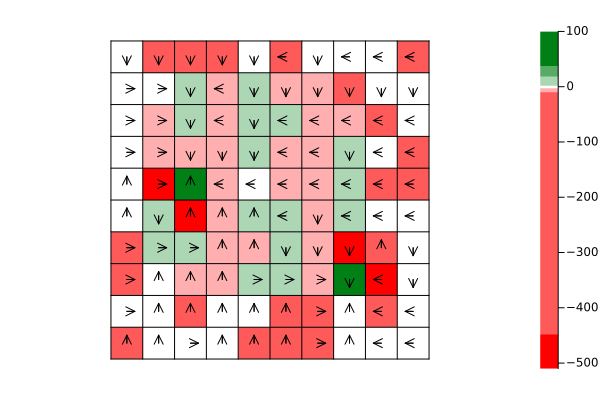

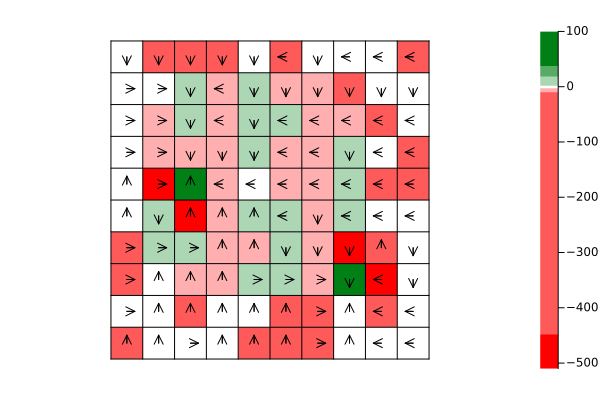

In [336]:
policy_plot(policy_Q_noact, R_mat)

In [341]:
norm(policy_Q_noact - policy_Q_act)

0.0

### Value Iteration on base dataset

[Iteration 1   ] residual:        500 | iteration runtime:      0.076 ms, (  7.62E-05 s total)
[Iteration 2   ] residual:       81.4 | iteration runtime:      0.067 ms, (  0.000143 s total)
[Iteration 3   ] residual:       65.7 | iteration runtime:      0.067 ms, (   0.00021 s total)
[Iteration 4   ] residual:       55.3 | iteration runtime:      0.066 ms, (  0.000276 s total)
[Iteration 5   ] residual:       35.4 | iteration runtime:      0.095 ms, (  0.000371 s total)
[Iteration 6   ] residual:       29.1 | iteration runtime:      0.140 ms, (   0.00051 s total)
[Iteration 7   ] residual:       24.7 | iteration runtime:      0.149 ms, (   0.00066 s total)
[Iteration 8   ] residual:         21 | iteration runtime:      0.093 ms, (  0.000752 s total)
[Iteration 9   ] residual:       17.3 | iteration runtime:      0.134 ms, (  0.000886 s total)
[Iteration 10  ] residual:       15.3 | iteration runtime:      0.142 ms, (   0.00103 s total)
[Iteration 11  ] residual:       13.6 | iteration 

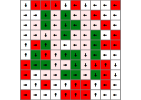

In [279]:
# Use value iteration to solve

using POMDPs
using POMDPModels
using POMDPTools

using CSV
using DataFrames
using Random

using DiscreteValueIteration
using Plots

n = 10
R = R_mat

reward_function = Dict() 
terminate = Dict()

# Count back through rows
for i in n:-1:1
    # Count forward through columns
    for j in 1:n
        reward_function[GWPos(j, i)] = R[(n-(i-1)), j]
    end
end

terminate[GWPos(3, 5)] = 0
#terminate[GWPos(8, 3)] = 90


mdp = SimpleGridWorld(
    size = (n, n),
    rewards = reward_function,
    terminate_from = Set(keys(terminate)),
    tprob = 0.9,
    discount = 0.9
)

solver = ValueIterationSolver(max_iterations=100, belres=1e-6, verbose=true); # creates the solver
policy = solve(solver, mdp); # runs value iterations

# policy = RandomPolicy(mdp) # Generate a random Policy

render(mdp; policy)

### Build Random Rewards

In [328]:
using LinearAlgebra

function build_world_rewards(n, start_pos)
    # Generate random gridworld
    R = rand([-1,10], n, n)
    R[start_pos[1], start_pos[2]] = 0

    num_aliens = Int64(round(0.02*n^2))
    aliens = zeros(num_aliens, 2)

     for alien in 1:num_aliens
        # Set position of aliens in grid
        # For convenience, avoid placing aliens directly
        # next to the cave bounds
        alien_row = rand(2:n-1)
        alien_col = rand(2:n-1)
        aliens[alien, 1] = alien_row
        aliens[alien, 2] = alien_col

        for i in 1:2
            # Set dangerous positions around aliens
            if i == 1
                dang_row = alien_row - rand([-1,1])
                dang_col = alien_col
            else
                dang_col = alien_col - rand([-1,1])
                dang_row = alien_row
            end

            R[dang_row, dang_col] = -500
        end

        # Set remaining random dangerous surfaces
        R[rand(1:n), rand(1:n)] = -500

        # Set positions of aliens
        R[alien_row, alien_col] = 100;

    end

    # Generate Rewards for Poor Signal
    signal = zeros(n,n)
    for i in 1:n
        for j in 1:n
            pos = [i, j]
            dist = norm(pos - start_pos)
            if dist > 15
                signal[i,j] = -20
            elseif dist > 8
                signal[i,j] = -15
            elseif dist >= 4
                signal[i,j] = -10
            end
        end
    end

    R += signal
    return aliens, R
end


build_world_rewards (generic function with 1 method)

### Use Value Iteration to solve Random map

[Iteration 1   ] residual:        515 | iteration runtime:      0.228 ms, (  0.000228 s total)
[Iteration 2   ] residual:         70 | iteration runtime:      0.156 ms, (  0.000384 s total)
[Iteration 3   ] residual:       46.5 | iteration runtime:      0.157 ms, (  0.000541 s total)
[Iteration 4   ] residual:       39.5 | iteration runtime:      0.200 ms, (  0.000741 s total)
[Iteration 5   ] residual:       34.5 | iteration runtime:      0.140 ms, (  0.000881 s total)
[Iteration 6   ] residual:       29.9 | iteration runtime:      0.145 ms, (   0.00103 s total)
[Iteration 7   ] residual:       25.7 | iteration runtime:      0.140 ms, (   0.00117 s total)
[Iteration 8   ] residual:       21.8 | iteration runtime:      0.141 ms, (   0.00131 s total)
[Iteration 9   ] residual:       18.9 | iteration runtime:      0.141 ms, (   0.00145 s total)
[Iteration 10  ] residual:       16.4 | iteration runtime:      0.164 ms, (   0.00161 s total)
[Iteration 11  ] residual:       13.4 | iteration 

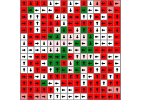

In [332]:
# Use value iteration to solve

using POMDPs
using POMDPModels
using POMDPTools

using CSV
using DataFrames
using Random

using DiscreteValueIteration
using Plots

n = 15
start_pos = [8,8]
Random.seed!(10)
aliens, R = build_world_rewards(n, start_pos)

reward_function = Dict() 
terminate = Dict()

# Count back through rows
for i in n:-1:1
    # Count forward through columns
    for j in 1:n
        reward_function[GWPos(j, i)] = R[(n-(i-1)), j]
    end
end

terminate[GWPos(3, 5)] = 0

#=
for k in length(aliens[:,1])
    row = n - (aliens[k, 1] - 1)
    col = aliens[k, 2]
    terminate[GWPos(col, row)] = 100
end
=#

mdp = SimpleGridWorld(
    size = (n, n),
    rewards = reward_function,
    terminate_from = Set(keys(terminate)),
    tprob = 0.9,
    discount = 0.9
)

solver = ValueIterationSolver(max_iterations=100, belres=1e-6, verbose=true); # creates the solver
policy = solve(solver, mdp); # runs value iterations

# policy = RandomPolicy(mdp) # Generate a random Policy

render(mdp; policy)

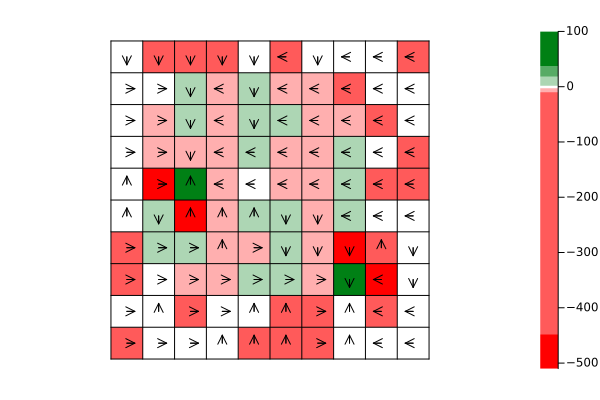

In [316]:
policy_val_iter = [2,4,4,4,1,1,4,4,4,4,
                   2,4,4,4,4,2,4,4,1,4,
                   2,2,2,2,1,1,4,4,4,4,
                   2,3,3,3,3,1,1,4,4,1,
                   2,2,2,3,3,1,4,4,1,1,
                   3,3,3,3,3,2,2,4,1,1,
                   2,3,3,3,3,2,2,4,4,4,
                   3,3,3,3,3,3,2,2,1,1,
                   3,3,3,3,3,3,1,3,3,3,
                   3,3,3,3,3,3,2,2,3,3]

policy_plot(policy_val_iter, R_mat)

### Total undiscounted reward earned if agent takes optimal action once at each state

In [306]:
function total_reward(policy, R, transition, action_rewards)

    r_cum = 0

    for i in 1:length(policy)
        
        s = i
        
        # Determine next state
        a = policy[i]
        sp = next_state(s, a, transition, n)

        # Determine reward from action
        r = R[sp]

        if action_rewards
            if sp == s
                r = -10 #negative reward for hitting wall
            end

            # Movement Penalty
            r = r-1
        end
        r_cum += r
    end
    return r_cum
end

total_reward (generic function with 3 methods)

In [321]:
r_Q = total_reward(policy_Q, R_new, transition, false)

959

In [322]:
r_value_iter = total_reward(policy_val_iter, R_new, transition, false)

938

In [323]:
Random.seed!(228)
policy_random = rand(1:4,n^2);
r_random = total_reward(policy_random, R_new, transition)

-3759

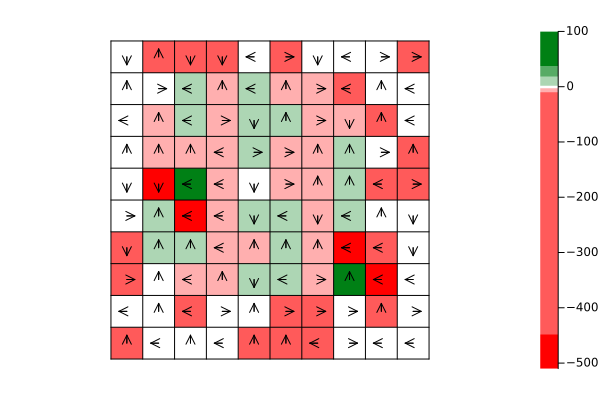

In [324]:
policy_plot(policy_random, R_mat)

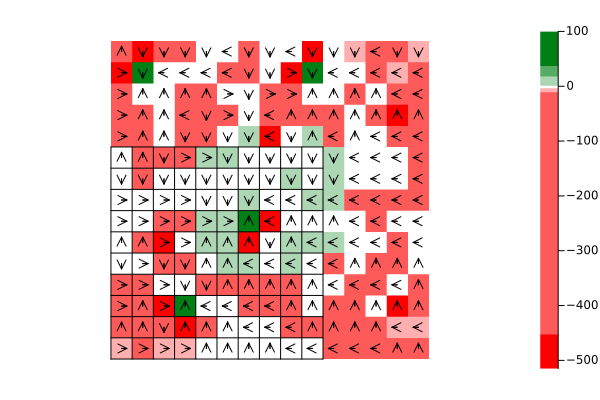

In [329]:
n = 15
size = [n, n]
start_pos = [8,8]
start_ind = sub2ind(size, start_pos)

S = collect(1:n^2)
A = collect(1:4)
Random.seed!(10)
aliens, R_matrix_15 = build_world_rewards(n, start_pos)

R = reshape(R_matrix_15, n^2, 1)
k = 100000 #Number of iterations
transition = Dict([(1, -1), (2, 1), (3, -n), (4, n)])
terminal = [26]
eps = 0.9 #Exploration Constant

Q1, policy_Q15 = final_q_learning(S, A, R, transition, eps, terminal, k)
policy_plot(policy_Q15, R_matrix_15)

In [ ]:
n = 10
size = [n, n]
start_pos = [5,5]
start_ind = sub2ind(size, start_pos)

S = collect(1:n^2)
A = collect(1:4)
R = R_new
#R = reshape(build_world_rewards(n, start_pos), n^2, 1)
k = 100000 #Number of iterations
transition = Dict([(1, -1), (2, 1), (3, -n), (4, n)])
terminal = [26]
eps = 0.9 #Exploration Constant

Q1, policy_Q_act = final_q_learning(S, A, R, transition, eps, terminal, k)

policy_plot(policy_Q_act, R_mat)
